In [1]:
from precovery import precovery_db
from precovery.orbit import Orbit, EpochTimescale
import pandas as pd
import os
import matplotlib.pyplot as plt
from astropy.time import Time
from dataclasses import asdict
import numpy as np
import time
from multiprocessing.pool import Pool

In [2]:
nside32_dir = "/home/data/db/ndet4_nside32/"

In [3]:
pre = precovery_db.PrecoveryDatabase.from_dir(nside32_dir)

In [4]:
#use hdf5 instead of csv

In [5]:
max_matches = None
tolerance = 0.00277778


In [6]:
orbit_sample = pd.read_csv("orbit_sample.csv")

In [7]:
epoch_tdb = Time(orbit_sample.mjd_tdb, scale="tdb", format="mjd")
epoch_utc = epoch_tdb.utc.mjd
orbit_sample['mjd_tdb'] = epoch_utc
orbit_sample

,orb_id,a,e,i,an,ap,ma,mjd_tdb,orb_type
0,2019LU1,1.526907,0.875733,7.350948,75.639405,316.863451,336.094575,58638.999199,NEO
1,2018GR4,0.936050,0.111033,1.004395,167.587963,232.868431,76.288516,59799.999199,NEO
2,2017FO128,1.739187,0.519446,17.129294,174.902988,301.103331,143.395668,59799.999199,NEO
3,2018GE2,1.086291,0.226287,0.474944,42.373753,74.930537,354.804243,59799.999199,NEO
4,2019AU6,0.983432,0.281890,0.348571,301.945762,278.136231,162.592997,59799.999199,NEO
...,...,...,...,...,...,...,...,...,...
117,2001 QA17,2.523522,0.125979,4.221790,16.221720,45.845290,11.554210,59799.999199,MBA
118,4526 P-L,2.433919,0.143933,2.346580,358.002490,138.643630,345.026880,59799.999199,MBA
119,1971 QW1,3.022948,0.081196,9.953170,208.820800,205.751090,191.282760,59799.999199,MBA
120,1951 RB,2.572736,0.147825,8.442690,324.141040,106.567870,16.585010,59799.999199,MBA


,obj_id,runtime,window_size,observation_id


In [41]:
def compare(orbit, obj_id, window): #compares lists and adds key of window size and accuracy to dictionary
    start = time.time()
    obs_list = []
    try:
        test = pd.DataFrame([asdict(m) for m in pre.precover(orbit, tolerance = tolerance, max_matches = max_matches, window_size = window)])
        if (test.size > 0):
            obs_list = list(test['observation_id'])
        else:
            obs_list = []
    except Exception as e:
        obs_list = [f'Error: {str(e)}']
    end = time.time()
    return [obj_id, end - start, window, obs_list]

In [11]:
windows = [3, 7, 10, 15, 20, 25, 30, 50, 100, 200]

In [12]:
orb_list = []
for index, row in orbit_sample.iterrows():
    orb_list.append((Orbit.keplerian(
        index,
        row.a,
        row.e,
        row.i,
        row.an,
        row.ap,
        row.ma,
        row.mjd_tdb,
        EpochTimescale.UTC,
        20,
        0.15
    ), 
    row.orb_id
    ))
    


In [34]:
orb_list[3][1]

'2018GE2'

In [37]:
compare(orb_list[3][0], orb_list[3][1], 200)

Empty DataFrame
Columns: []
Index: []


['2018GE2', 23.134432792663574, 200, ["Error: 'observation_id'"]]

In [44]:
data = pd.DataFrame(columns = ['obj_id', 'runtime', 'window_size', 'observation_id'])
workercount = 28
start = time.time()
if __name__ == '__main__':
    with Pool(workercount) as pool:
        for i in windows:
            items = []
            window_start = time.time()
            print(f'\n========================================================================')
            print(f'==================== Beginning work on window size: {i} ==============')
            print(f'========================================================================')
            for j in orb_list:
                items += [(j[0], j[1], i)]
            for result in pool.starmap(compare, items):
                data.loc[result[0] + ' Size ' + str(result[2])] = result
            window_end = time.time()
            
            print(f'==================== Window took: {(window_end-window_start)/60.0} minutes to process  {len(items)} items ==============')
            print(f'==================== an average of roughly {(window_end-window_start) / (len(items) / workercount)} seconds per precovery ==============')

            
end = time.time()
print(f'\n========================================================================')
print(f'==================== Entire run took: {end-start} seconds ==============')
print(f'========================================================================')


==================== Beginning work on window size: 3 ==============
==================== Window took: 8.133326196670533 minutes to process  122 items ==============
==================== an average of roughly 111.99990172464341 seconds per precovery ==============

==================== Beginning work on window size: 7 ==============
==================== Window took: 5.556792521476746 minutes to process  122 items ==============
==================== an average of roughly 76.51976586951585 seconds per precovery ==============

==================== Beginning work on window size: 10 ==============
==================== Window took: 5.078862949212392 minutes to process  122 items ==============
==================== an average of roughly 69.93844061210508 seconds per precovery ==============

==================== Beginning work on window size: 15 ==============
==================== Window took: 4.601386014620463 minutes to process  122 items ==============
==================== an average of 

In [45]:
data

,obj_id,runtime,window_size,observation_id
2019LU1 Size 3,2019LU1,73.960715,3,[c4d.860949.34.1152]
2018GR4 Size 3,2018GR4,116.183861,3,"[c4d.735460.34.1098, c4d.735460.34.1099, c4d.7..."
2017FO128 Size 3,2017FO128,109.663043,3,"[ksb.78400037.4.3087, c4d.642090.6.666]"
2018GE2 Size 3,2018GE2,113.154870,3,"[c4d.738829.42.879, c4d.738757.42.278, c4d.741..."
2019AU6 Size 3,2019AU6,135.638142,3,[c4d.808334.24.140]
...,...,...,...,...
2001 QA17 Size 200,2001 QA17,23.512584,200,"[c4d.418645.6.55, c4d.418644.7.117, c4d.392881..."
4526 P-L Size 200,4526 P-L,27.894994,200,"[c4d.392846.45.420, c4d.392845.45.645, c4d.430..."
1971 QW1 Size 200,1971 QW1,23.079719,200,"[c4d.257453.21.885, c4d.252104.47.203, c4d.247..."
1951 RB Size 200,1951 RB,27.392527,200,"[c4d.570123.16.7976, c4d.662389.28.748, c4d.66..."


In [86]:
def timevwindow(obj_id, df):
    # fit = np.polyfit(np.log(df[df['obj_id'] == obj_id]['runtime']), df[df['obj_id'] == obj_id]['window_size'], 1)
    plt.plot(df[df['obj_id'] == obj_id]['window_size'], df[df['obj_id'] == obj_id]['runtime'], 'ro')
    # plt.plot(df[df['obj_id'] == obj_id]['runtime'], fit[0] + fit[1]*np.log(df[df['obj_id'] == obj_id]['runtime']))
    plt.title('Runtime vs. Window Size of ' + obj_id)
    plt.xlabel('Window Size')
    plt.ylabel('Runtime (sec)')
    plt.show()
def completenessvwindow(obj_id, df):
    # fit = np.polyfit(np.log(df[df['obj_id'] == obj_id]['accuracy']), df[df['obj_id'] == obj_id]['window_size'], 1)
    plt.plot(df[df['obj_id'] == obj_id]['window_size'], df[df['obj_id'] == obj_id]['accuracy'], 'ro')
    # plt.plot(df[df['obj_id'] == obj_id]['accuracy'], fit[0] + fit[1]*np.log(df[df['obj_id'] == obj_id]['accuracy']))
    plt.title('Runtime vs. Window Size of ' + obj_id)
    plt.xlabel('Window Size')
    plt.ylabel('Accuracy')
    plt.show()

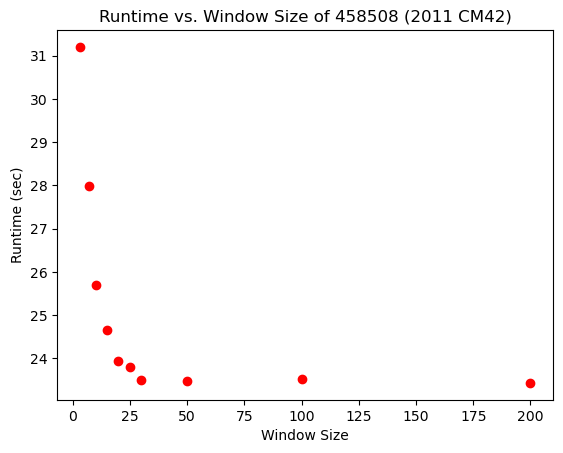

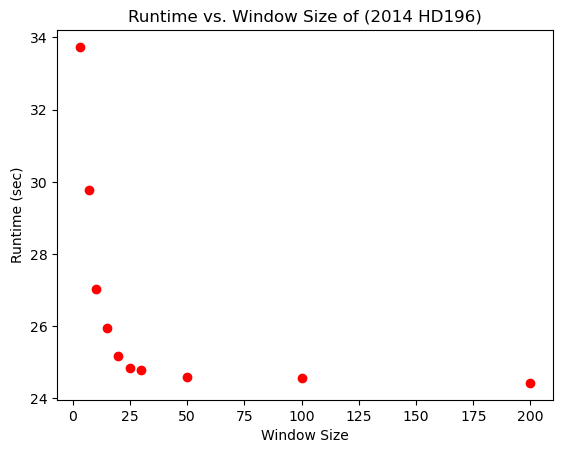

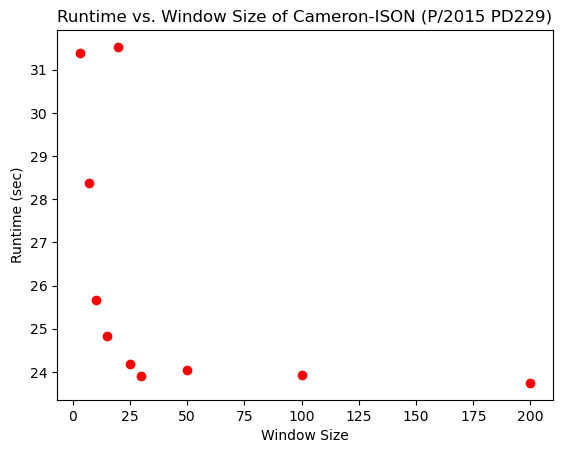

(None, None, None)

In [87]:
timevwindow('458508 (2011 CM42)', data), timevwindow('(2014 HD196)', data), timevwindow('Cameron-ISON (P/2015 PD229)', data)

In [88]:
def accuracy(orbit_name, data_frame):
    base = len(list(data_frame.loc[orbit_name + ' Size 3']['observation_id']))
    lst = list(data_frame[data_frame['obj_id'] == orbit_name]['observation_id'])
    return [len(i) / base for i in lst]
        

In [89]:
accuracy('458508 (2011 CM42)', data), accuracy('(2014 HD196)', data), accuracy('Cameron-ISON (P/2015 PD229)', data)

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [46]:
data.to_hdf('data.h5', key = 'df', mode = 'w')
#pd.read_hdf('data.h5', key = 'df')

/tmp/ipykernel_1222/1552046964.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['obj_id', 'observation_id'], dtype='object')]

  data.to_hdf('data.h5', key = 'df', mode = 'w')


In [91]:
pd.read_hdf('data.h5', key = 'df')

,obj_id,runtime,window_size,observation_id
458508 (2011 CM42) Size 3,458508 (2011 CM42),31.205024,3,"[c4d.230114.59.331, c4d.230825.30.319, c4d.232..."
(2014 HD196) Size 3,(2014 HD196),33.736597,3,[c4d.295769.35.771]
Cameron-ISON (P/2015 PD229) Size 3,Cameron-ISON (P/2015 PD229),31.377840,3,"[c4d.442678.33.4457, c4d.469410.35.595, c4d.46..."
458508 (2011 CM42) Size 7,458508 (2011 CM42),27.981865,7,"[c4d.230114.59.331, c4d.232759.5.1678, c4d.232..."
(2014 HD196) Size 7,(2014 HD196),29.780106,7,[c4d.295769.35.771]
Cameron-ISON (P/2015 PD229) Size 7,Cameron-ISON (P/2015 PD229),28.377120,7,"[c4d.442678.33.4457, c4d.469410.35.595, c4d.46..."
458508 (2011 CM42) Size 10,458508 (2011 CM42),25.697379,10,"[c4d.233475.32.268, c4d.233473.32.288, c4d.233..."
(2014 HD196) Size 10,(2014 HD196),27.041998,10,[c4d.295769.35.771]
Cameron-ISON (P/2015 PD229) Size 10,Cameron-ISON (P/2015 PD229),25.657142,10,"[c4d.442678.33.4457, c4d.469410.35.595, c4d.46..."
458508 (2011 CM42) Size 15,458508 (2011 CM42),24.662964,15,"[c4d.232342.24.1141, c4d.232341.24.965, c4d.23..."
